In [1]:
import os
import networkx as nx
import numpy as np

In [2]:
import pickle
def load_graph(fn):
    with open(fn, "rb") as f:
        return pickle.load(f)
filenames = [fn for fn in os.listdir("../graphs/") if ".pkl" in fn]
graphs = [load_graph("../graphs/"+fn) for fn in filenames]

In [3]:
with open("../names_groups.pkl", "rb")  as f:
    names, groups = pickle.load(f)

In [4]:
import biograph.groupfolds
protein_group_dict = biograph.groupfolds.CDHitGroup.get_protein_groups(names, groups)
protein_ids = []
for graph in graphs:
    node_idx = list(graph.nodes)[0]
    protein_ids.append(graph.nodes[node_idx]["full_id"][0])
protein_groups = [protein_group_dict.get(pdbid, -1) for pdbid in protein_ids]
"There are {} proteins without group".format(len(list(filter(lambda g: g==-1, protein_groups))))

'There are 1 proteins without group'

In [5]:
notin = 0
total = 0
chainnot = {}
for graph in graphs:
    for node_idx in graph.nodes:
        total+=1
        chain = graph.nodes[node_idx]["chain"]
        if chain not in groups:
            notin+=1
            graph.nodes[node_idx]["group"] = None
            chainnot[chain] = chainnot.get(chain, 0) + 1
        else:
            graph.nodes[node_idx]["group"] = chain
notin, notin/total *100, chainnot

(247, 0.02368611581263995, {'5A99_A': 247})

In [6]:
def remove_interior(graph):
    edges_to_remove = set()
    nodes_to_remove = set()
    for node_idx, adj_dict in graph.adjacency():
        neighbors_not_in_surf = [k for k,v in adj_dict.items() if not v["in_surf"]]
        edges_to_remove.update([
            (node_idx, neighbor)  if node_idx < neighbor else (neighbor, node_idx) 
            for neighbor in neighbors_not_in_surf])
        if len(adj_dict) == len(neighbors_not_in_surf):
            nodes_to_remove.add(node_idx)
    edges_before = graph.number_of_edges()
    nodes_before = graph.number_of_nodes()
    for edge in edges_to_remove:
        graph.remove_edge(*edge)
    for idx in nodes_to_remove:
        graph.remove_node(idx)
    return graph
#edges_before, graph.number_of_edges(), nodes_before, graph.number_of_nodes()

In [7]:
graphs = [remove_interior(graph) for graph in graphs]

In [8]:
graphs[0].nodes == graphs[0].nodes()

True

In [9]:
import biograph.constants
index_amino = {code3:i for i, code3 in enumerate(biograph.constants.AMINOACIDS_3)}
index_amino["UNK"] = len(index_amino)
num_amino = len(index_amino)

# Features are aminoacid type, bfactor and x,y,z coord.
all_features = []
for graph in graphs:
    features = np.zeros((graph.number_of_nodes(), num_amino + 4))
    for i, node_idx in enumerate(graph.nodes):
        node = graph.nodes[node_idx]
        #features[i, 0:num_amino+4] = 1
        features[i, index_amino[node["resname"]]] = 1
        features[i, num_amino] = node["bfactor"]
        features[i, num_amino+1:num_amino+4] = node["coord"]
        
    all_features.append(features)

(array([200., 507., 292.,  95.,  64.,  41.,  13.,  10.,   1.,   5.]),
 array([  61.,  186.,  311.,  436.,  561.,  686.,  811.,  936., 1061.,
        1186., 1311.]),
 <a list of 10 Patch objects>)

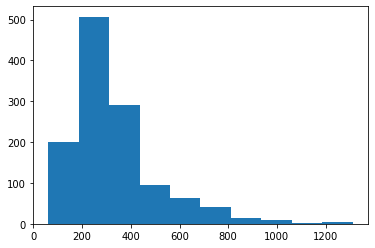

In [10]:
import matplotlib.pyplot as plt
plt.hist([features.shape[0] for features in all_features])

In [11]:
len(all_features), len([features for features in all_features if features.shape[0]<1000])

(1228, 1218)

In [12]:
len(protein_ids)

1228

In [13]:
all_adj = [nx.adjacency_matrix(graph) for graph in graphs]

In [14]:
def touches_ligand(x):
    return x <= 4 or (x<=6 and np.random.binomial(1, 1-(x-4)/2) == 1)

class_balance = []
all_targets = []
for graph in graphs:
    targets = np.zeros((graph.number_of_nodes()))
    for i, node_idx in enumerate(graph.nodes):
        distance = graph.nodes[node_idx]["distance"]
        targets[i] = 1 if touches_ligand(distance) else 0
    class_balance.append(targets.sum() / (targets.shape[0]- targets.sum()))
    all_targets.append(targets)

In [15]:
all_adj[0].astype(np.float32)

<322x322 sparse matrix of type '<class 'numpy.float32'>'
	with 1944 stored elements in Compressed Sparse Row format>

In [16]:
# filter and cast to float32 (default for tf)
keep = [features.shape[0]<1000 for features in all_features]
all_features = [features.astype(np.float32) for i, features in enumerate(all_features) if keep[i]]
all_adj = [adj.astype(np.float32) for i, adj in enumerate(all_adj) if keep[i]]
all_targets = [targets.astype(np.float32) for i, targets in enumerate(all_targets) if keep[i]]
protein_groups = [g for i, g in enumerate(protein_groups) if keep[i]]

In [17]:
fair_positive_weight = 1/(sum(class_balance)/len(class_balance))
print("For every non-contact point there are {} contact points".format(
    sum(class_balance)/len(class_balance)))
fair_positive_weight

For every non-contact point there are 0.028800538396223152 contact points


34.7215731262558

## Model

In [18]:
import scipy.sparse as sp
import numpy as np

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

class Laplacian:
    @staticmethod
    def from_adjacency(adj):
        adj = adj + sp.eye(adj.shape[0])
        """Symmetrically normalize adjacency matrix."""
        adj = sp.coo_matrix(adj)
        rowsum = np.array(adj.sum(1))
        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
        return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


In [19]:
all_adj = [sparse_to_tuple(Laplacian.from_adjacency(adj)) 
            for adj in all_adj]
#all_features = [preprocess_features(sp.lil_matrix(features))
#            for features in all_features]

nb_nodes_per_graph = [adj[2][1] for adj in all_adj]
nb_nodes = max(map(lambda adj: adj[2][1], all_adj))
nb_nodes

992

In [20]:
# Make sparse matrices the same size
for i, adj_tuple in enumerate(all_adj):
    #adj_tuple[2] is the shape, and we want it to be always the same..
    all_adj[i] = (adj_tuple[0], adj_tuple[1], (nb_nodes, nb_nodes))

# Make features the same size as well via padding

for i, features in enumerate(all_features):
    amount = nb_nodes-features.shape[0]
    all_features[i] = np.pad(features, ((0,amount), (0,0)))
    
for i, target in enumerate(all_targets):
    amount = nb_nodes-target.shape[0]
    all_targets[i] = np.pad(target, (0,amount))

masks_all = []
for n in nb_nodes_per_graph:
    mask = np.pad(np.ones(n), (0, nb_nodes - n)).astype(np.float32)
    masks_all.append(mask)

In [42]:
import tensorflow as tf
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [37]:
import gcn.gcn as gcn
from importlib import reload
reload(gcn)

<module 'gcn.gcn' from '/home/joaquintz/research/thesis/src/gcn/gcn.py'>

### CV model

In [23]:
tf.data.Dataset.from_tensor_slices = lambda a: a 
feats = all_features
supps = [tf.sparse.SparseTensor(indices, values.astype(np.float32), dense_shape)
            for indices, values, dense_shape in all_adj]
targs = all_targets
masks = masks_all

In [43]:
model = gcn.GraphConvolutionalNetwork(all_features[0].shape, 1, all_adj[0][2])

In [ ]:
model.fit_cv_groups((feats, supps, targs, masks), protein_groups,
                   positive_weight=34, epochs=40)


Resetting weights..
Start of epoch 0
Epoch 0:
	TRAIN loss 0.38, auc 0.59, recall 0.20, precision 0.03
	VAL loss 0.37 auc 0.59 recall 0.04 precision 0.03
Confusion matrix(TRAIN):
[[259536  48380]
 [  6617   2438]]
Confusion matrix(VAL):
[[70539  2162]
 [ 1609    72]]
Start of epoch 1
Epoch 1:
	TRAIN loss 0.37, auc 0.61, recall 0.24, precision 0.03
	VAL loss 0.36 auc 0.61 recall 0.06 precision 0.04
Confusion matrix(TRAIN):
[[256662  51254]
 [  6347   2708]]
Confusion matrix(VAL):
[[70243  2458]
 [ 1583    98]]
Start of epoch 2
Epoch 2:
	TRAIN loss 0.37, auc 0.62, recall 0.32, precision 0.03
	VAL loss 0.36 auc 0.62 recall 0.12 precision 0.04
Confusion matrix(TRAIN):
[[241428  66488]
 [  5834   3221]]
Confusion matrix(VAL):
[[67861  4840]
 [ 1481   200]]
Start of epoch 3
Epoch 3:
	TRAIN loss 0.37, auc 0.63, recall 0.38, precision 0.03
	VAL loss 0.36 auc 0.62 recall 0.17 precision 0.04
Confusion matrix(TRAIN):
[[231908  76008]
 [  5395   3660]]
Confusion matrix(VAL):
[[66100  6601]
 [ 1394 

Epoch 33:
	TRAIN loss 0.33, auc 0.76, recall 0.62, precision 0.06
	VAL loss 0.36 auc 0.67 recall 0.48 precision 0.05
Confusion matrix(TRAIN):
[[233257  95960]
 [ 24998  26659]]
Confusion matrix(VAL):
[[56571 18686]
 [ 3429  3364]]
Start of epoch 34


### Train test split

In [ ]:
len(protein_ids), len(all_features)

In [ ]:
protein_ids

In [81]:
def split_list(data, train_perc, val_perc):
    num_train = int(len(data) * train_perc)
    num_val = int(len(data) * val_perc)
    return data[:num_train], data[num_train:num_train+num_val], data[num_train+num_val:]

features_train, features_val, features_test = split_list(all_features, 0.70, 0.15)
adj_train, adj_val, adj_test = split_list(all_adj, 0.70, 0.15)
y_train, y_val, y_test = split_list(all_targets, 0.70, 0.15)
nodes_train, nodes_val, nodes_test = split_list(nb_nodes_per_graph, 0.70, 0.15)
masks_train, masks_val, masks_test = split_list(masks_all, 0.70, 0.15)

In [82]:
#%load_ext tensorboard
tf.data.Dataset.from_tensor_slices = lambda a: a 
feats_tr = tf.data.Dataset.from_tensor_slices(features_train)
supps_tr = [tf.sparse.SparseTensor(indices, values.astype(np.float32), dense_shape)
            for indices, values, dense_shape in adj_train]
targs_tr = tf.data.Dataset.from_tensor_slices(y_train)
masks_tr = tf.data.Dataset.from_tensor_slices(masks_train)

feats_vl = tf.data.Dataset.from_tensor_slices(features_val)
supps_vl = [tf.sparse.SparseTensor(indices, values.astype(np.float32), dense_shape)
            for indices, values, dense_shape in adj_val]
targs_vl = tf.data.Dataset.from_tensor_slices(y_val)
masks_vl = tf.data.Dataset.from_tensor_slices(masks_val)


In [88]:
type(feats_tr[0]), type(supps_tr[0]), type(targs_tr[0]), type(masks_tr[0])

(numpy.ndarray,
 tensorflow.python.framework.sparse_tensor.SparseTensor,
 numpy.ndarray,
 numpy.ndarray)

In [89]:
type(feats[0]), type(supps[0]), type(targs[0]), type(masks[0])

(numpy.ndarray,
 tensorflow.python.framework.sparse_tensor.SparseTensor,
 numpy.ndarray,
 numpy.ndarray)

In [83]:
model = gcn.GraphConvolutionalNetwork(features_train[0].shape, 1, adj_train[0][2])

In [84]:
model.fit((feats_tr, targs_tr, supps_tr, masks_tr), 
          (feats_vl, targs_vl, supps_vl, masks_vl), 
          epochs=100, positive_weight=34)

Start of epoch 0
Epoch 0:
	TRAIN loss 0.38, auc 0.59, recall 0.15, precision 0.03
	VAL loss 0.39 auc 0.59 recall 0.33 precision 0.03
Confusion matrix(TRAIN):
[[230182  35424]
 [  7864   3468]]
Confusion matrix(VAL):
[[42844 15159]
 [  919   460]]
Start of epoch 1


KeyboardInterrupt: 

In [ ]:
model.weights[0].numpy().sum()

In [ ]:
model.reset_states()

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np
all_predicted = []
all_real = []
for x, y, L, mask in zip(feats_vl, targs_vl, supps_vl, masks_vl):
    ỹ = model(x, L)
    ỹ = tf.reshape(ỹ, [-1])
    all_real.append(y)
    all_predicted.append(ỹ.numpy())

real = np.concatenate(all_real)
predicted = np.concatenate(all_predicted)

roc_auc_score(real, predicted)

In [ ]:
from sklearn.metrics import confusion_matrix
pred_classes = np.copy(predicted)
pred_classes[pred_classes > 0.5] = 1
pred_classes[pred_classes <= 0.5] = 0
confusion_matrix(real, pred_classes)

In [ ]:
ỹ

In [ ]:
greater = tf.math.greater(ỹ, 0.5)
tf.cast(tf.math.greater(ỹ, 0.5), tf.int32)  # [1, 2], dtype=tf.int32


In [ ]:
greater

In [ ]:
#

In [ ]:
#tf.Tensor([[0,0],[0,0]])

In [ ]:
model.conf_matrix + tf.math.confusion_matrix(y, ỹ, weights=mask)

In [ ]:
masks_val